In [1]:
import numpy as np 
import pandas as pd 

import seaborn as sns
from matplotlib import pyplot as plt
from xgboost import XGBClassifier, plot_importance

from sklearn.compose import make_column_transformer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

print("Features: ", "\n", train_data.columns.values)
print("\n", "Train data shape: ", train_data.shape)
print("\n", "Test data shape: ", test_data.shape)

Features:  
 ['id' 'CustomerId' 'Surname' 'CreditScore' 'Geography' 'Gender' 'Age'
 'Tenure' 'Balance' 'NumOfProducts' 'HasCrCard' 'IsActiveMember'
 'EstimatedSalary' 'Exited']

 Train data shape:  (165034, 14)

 Test data shape:  (110023, 13)


In [3]:
numerical_features = ['Age', 'Balance', 'CreditScore',  'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
train_data = train_data.drop_duplicates()

train_data[numerical_features + ['Exited']].describe(percentiles=[]).T.drop(columns=['count'])

,mean,std,min,50%,max
Age,38.125888,8.867205,18.00,37.0,92.00
Balance,55478.086689,62817.663278,0.00,0.0,250898.09
CreditScore,656.454373,80.103340,350.00,659.0,850.00
EstimatedSalary,112574.822734,50292.865585,11.58,117948.0,199992.48
HasCrCard,0.753954,0.430707,0.00,1.0,1.00
IsActiveMember,0.497770,0.499997,0.00,0.0,1.00
NumOfProducts,1.554455,0.547154,1.00,2.0,4.00
Tenure,5.020353,2.806159,0.00,5.0,10.00
Exited,0.211599,0.408443,0.00,0.0,1.00


In [4]:
categorical_features = ['Geography', 'Gender']
train_data[categorical_features].describe().T.drop(columns=['count'])

,unique,top,freq
Geography,3,France,94215
Gender,2,Male,93150


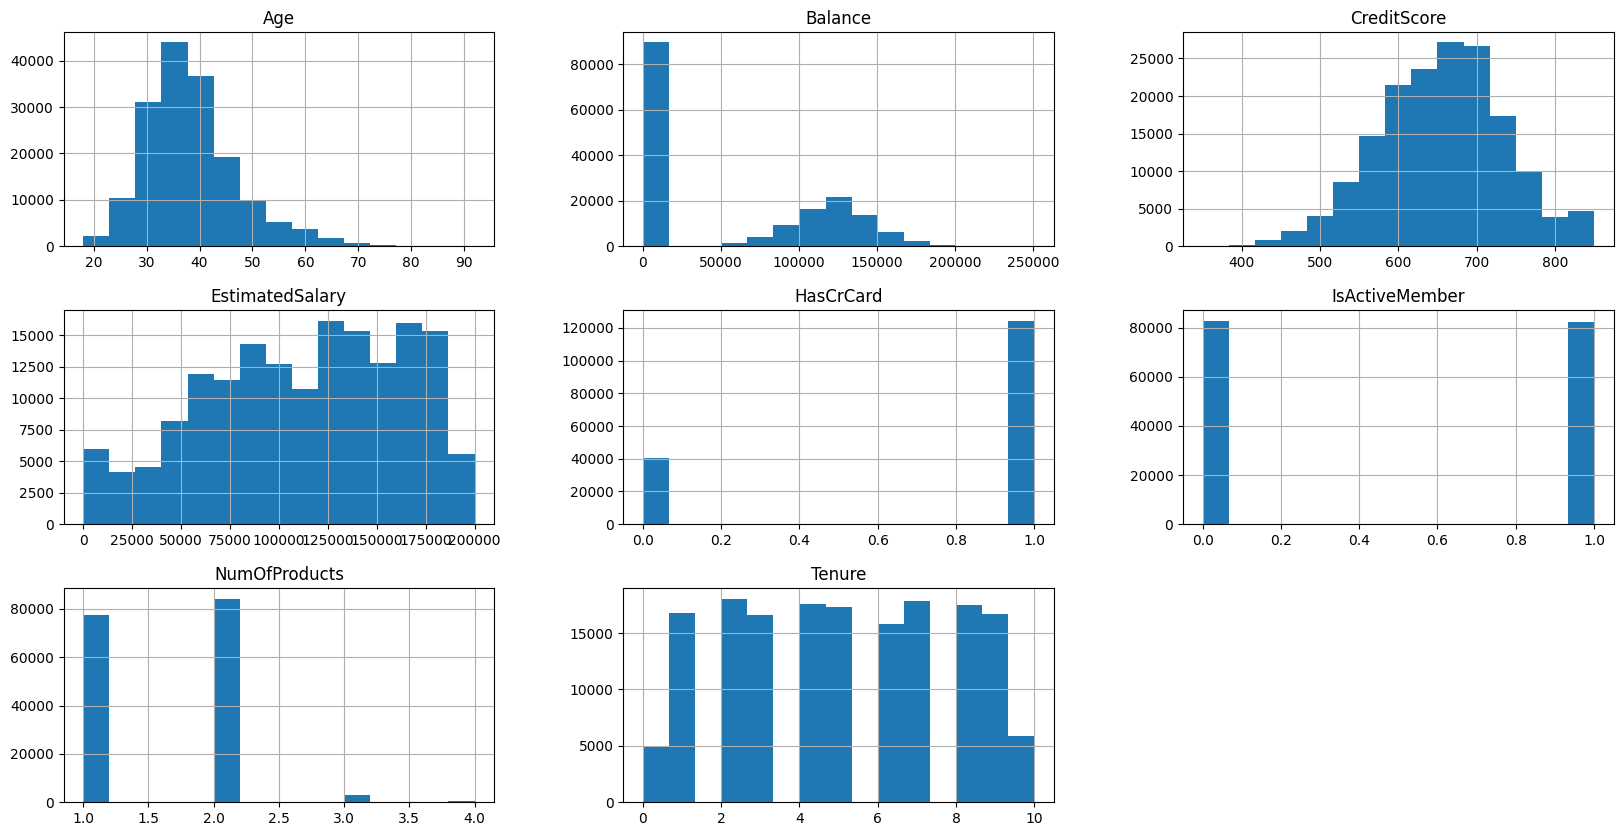

In [5]:
train_data.hist(column=numerical_features, figsize=(20,10), bins=15)
plt.show()

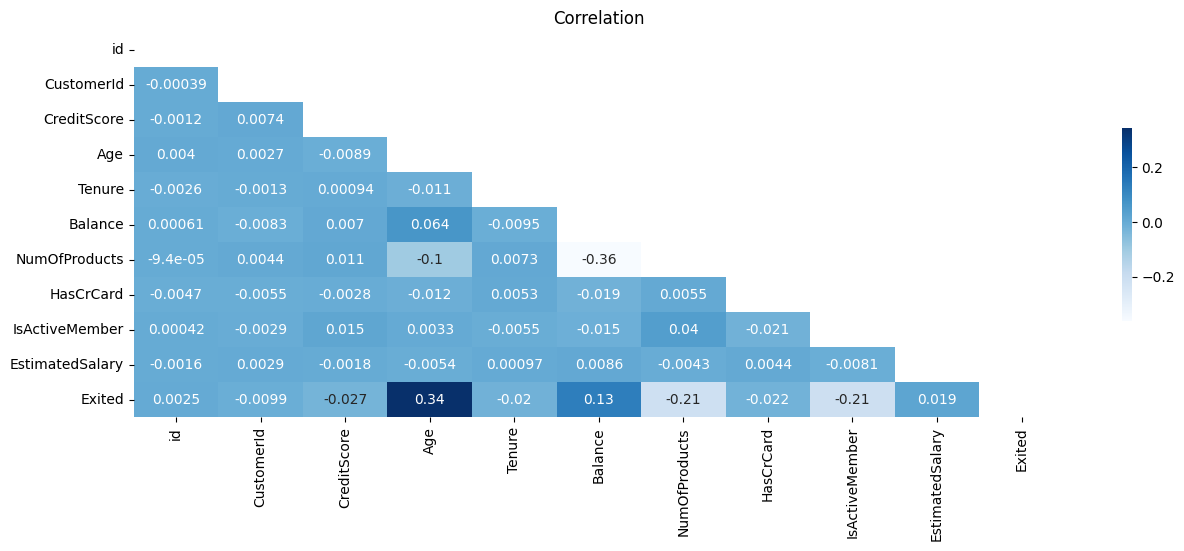

In [6]:
corr = train_data.corr(numeric_only=True)
plt.figure(figsize=(15, 5))
sns.heatmap(corr, mask=np.triu(corr), annot=True, cmap='Blues', cbar_kws={"shrink": .5})
plt.title("Correlation")
plt.show()

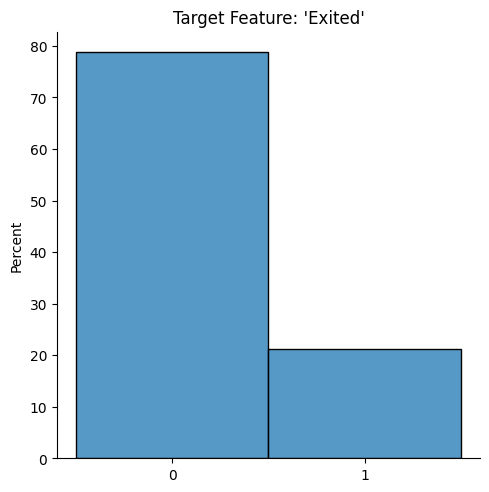

In [7]:
sns.displot(train_data.Exited.astype('str'), stat='percent', legend=True)
plt.title("Target Feature: 'Exited'")
plt.xlabel(None)
plt.show()

In [8]:
categorical_features = categorical_features
numerical_features = numerical_features

transformer = make_column_transformer(
    (StandardScaler(), numerical_features),
    (OneHotEncoder(), categorical_features), sparse_threshold=0)
transformed_data = transformer.fit_transform(train_data)

feature_names = [name.split("__")[-1] for name in transformer.get_feature_names_out()]
X = pd.DataFrame(transformed_data, columns=feature_names)
y = train_data['Exited']

transformed_data = transformer.fit_transform(test_data)
X_pred = pd.DataFrame(transformed_data, columns=feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) 
print("Features: ", "\n", X_train.columns.values)

Features:  
 ['Age' 'Balance' 'CreditScore' 'EstimatedSalary' 'HasCrCard'
 'IsActiveMember' 'NumOfProducts' 'Tenure' 'Geography_France'
 'Geography_Germany' 'Geography_Spain' 'Gender_Female' 'Gender_Male']


In [9]:
clf = XGBClassifier(objective='binary:logistic', 
                    eval_metric='auc',
                    random_state=42,
                    n_jobs=-1)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_pred = clf.predict(X_test)

print("AUC: %.2f%%" % (round(roc_auc_score(y_test, y_pred) * 100, 2)))

AUC: 75.11%


In [10]:
# Cross-validation
target = train_data.Exited.value_counts()
rs_params = {
 "learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree": [ 0.3, 0.4, 0.5 , 0.7 ],
 "scale_pos_weight": [target[0]/target[1]] 
}

rs_clf = RandomizedSearchCV(estimator=clf, 
                            scoring='roc_auc',
                            param_distributions=rs_params, 
                            random_state=42,
                            n_jobs=-1,
                            cv=10)
rs_clf.fit(X_train, y_train)

print("Best set of hyperparameters: ", "\n", rs_clf.best_params_)
print("AUC-ROC score: %.2f%%" % round(rs_clf.best_score_ * 100, 2))

Best set of hyperparameters:  
 {'scale_pos_weight': 3.72592422897397, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.2, 'gamma': 0.3, 'colsample_bytree': 0.4}
AUC-ROC score: 88.92%


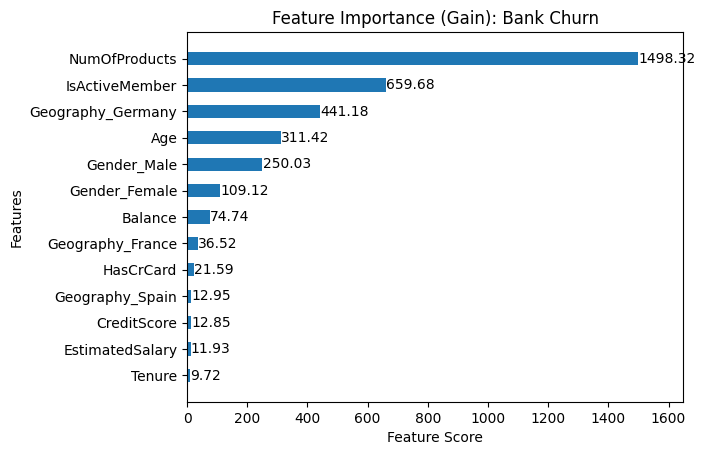

In [11]:
rs_importances = rs_clf.best_estimator_.get_booster().get_score(importance_type='gain')
plot_importance(rs_importances, max_num_features=20, grid=False, height=.5,
                title="Feature Importance (Gain): Bank Churn", values_format="{v:.2f}")
plt.xlabel("Feature Score")
plt.show()

In [12]:
submission = pd.read_csv('/kaggle/input/playground-series-s4e1/sample_submission.csv', index_col='id')
submission['Exited'] = rs_clf.best_estimator_.predict_proba(X_pred)[:,1]
submission.head()

,Exited
id,
165034,0.141644
165035,0.942116
165036,0.086733
165037,0.506479
165038,0.680514


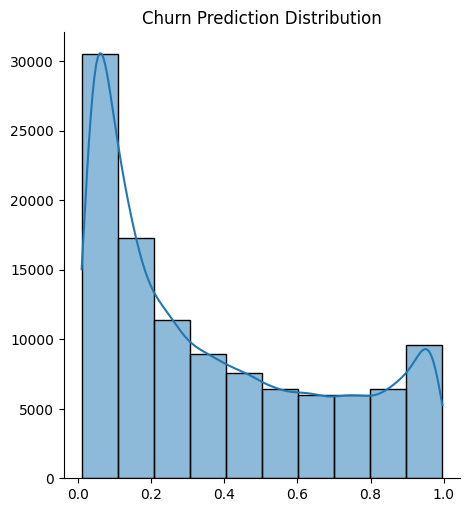

In [13]:
sns.displot(submission, kde=True, bins=10, legend=False)
plt.title("Churn Prediction Distribution")
plt.xlabel(None)
plt.ylabel(None)
plt.show()

In [14]:
submission.to_csv('submission.csv', index=False)